In [4]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
import sys
import os
import warnings

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor, RandomForestRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from datetime import timedelta
from lightgbm import LGBMRegressor
import utils as u
from sklearn.metrics import classification_report
import joblib

warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 1.26.4


## Loading meme data

In [5]:
gaming = pd.read_csv('../data-09/processed/gaming.csv')
ai = pd.read_csv('../data-09/processed/ai.csv')
meme = pd.read_csv('../data-09/processed/meme.csv')
rwa = pd.read_csv('../data-09/processed/rwa.csv')

gaming.shape, ai.shape, meme.shape, rwa.shape

((126980, 12), (114410, 12), (33454, 12), (52833, 12))

## Preprocessing data

In [6]:
days_to_predict = 7

In [7]:
class category_data:
    def __init__(self, train_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler):
        self.train_data = train_data
        self.series_dict = series_dict
        self.exog_dict = exog_dict
        self.future_exog_dict = future_exog_dict
        self.series_scaler = series_scaler
        self.exog_scaler = exog_scaler
        self.forecaster = None
        self.predictions = None
        self.og_train = None
        self.og_pred = None
        self.error_df = None
        self.close_df = None

In [8]:
def generate_data_object(data: pd.DataFrame, days: int):
    train_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler = u.preprocess_future(data, days_to_predict=days)
    data_obj = category_data(train_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler)
    return data_obj

In [9]:
gaming_obj = generate_data_object(gaming, days_to_predict)
ai_obj = generate_data_object(ai, days_to_predict)
meme_obj = generate_data_object(meme, days_to_predict)
rwa_obj = generate_data_object(rwa, days_to_predict)

### Checking the amount of tokens used

In [10]:
print(gaming_obj.train_data['id'].nunique())
print(ai_obj.train_data['id'].nunique())
print(meme_obj.train_data['id'].nunique())
print(rwa_obj.train_data['id'].nunique())

59
31
18
16


### Finding the best LGBM model with GridSearch

In [11]:
# gaming_obj.forecaster = u.train_best_forecaster(gaming_obj.series_dict, gaming_obj.exog_dict, gaming_obj.future_exog_dict, gaming_obj.test_data, future_days=days_to_predict)
# ai_obj.forecaster = u.train_best_forecaster(ai_obj.series_dict, ai_obj.exog_dict, ai_obj.future_exog_dict, ai_obj.test_data, future_days=days_to_predict)
# meme_obj.forecaster = u.train_best_forecaster(meme_obj.series_dict, meme_obj.exog_dict, meme_obj.future_exog_dict, meme_obj.test_data, future_days=days_to_predict)
# rwa_obj.forecaster = u.train_best_forecaster(rwa_obj.series_dict, rwa_obj.exog_dict, rwa_obj.future_exog_dict, rwa_obj.test_data, future_days=days_to_predict)

### Training with CatBoost

In [12]:
gaming_obj.forecaster = u.train_forecaster(gaming_obj.series_dict, gaming_obj.exog_dict)
ai_obj.forecaster = u.train_forecaster(ai_obj.series_dict, ai_obj.exog_dict)
meme_obj.forecaster = u.train_forecaster(meme_obj.series_dict, meme_obj.exog_dict)
rwa_obj.forecaster = u.train_forecaster(rwa_obj.series_dict, rwa_obj.exog_dict)

{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}
{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}
{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}
{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}


### Predicting the next 7 days

In [13]:
gaming_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=gaming_obj.forecaster, future_exog_dict=gaming_obj.future_exog_dict)
ai_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=ai_obj.forecaster, future_exog_dict=ai_obj.future_exog_dict)
meme_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=meme_obj.forecaster, future_exog_dict=meme_obj.future_exog_dict)
rwa_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=rwa_obj.forecaster, future_exog_dict=rwa_obj.future_exog_dict)

### Inverse scaling the data to get the real close prices

In [14]:
gaming_obj.og_train, gaming_obj.og_pred = u.inverse_scaling_future(train_df=gaming_obj.train_data, pred_df=gaming_obj.predictions, scalers=gaming_obj.series_scaler)
ai_obj.og_train, ai_obj.og_pred = u.inverse_scaling_future(train_df=ai_obj.train_data, pred_df=ai_obj.predictions, scalers=ai_obj.series_scaler)
meme_obj.og_train, meme_obj.og_pred = u.inverse_scaling_future(train_df=meme_obj.train_data, pred_df=meme_obj.predictions, scalers=meme_obj.series_scaler)
rwa_obj.og_train, rwa_obj.og_pred = u.inverse_scaling_future(train_df=rwa_obj.train_data, pred_df=rwa_obj.predictions, scalers=rwa_obj.series_scaler)

In [15]:
gaming_obj.og_pred

,06963e10-2042-41d3-9583-acb4135460dc,0844705f-10ed-42ca-b483-914b7d59e351,10e910bd-6f50-4085-bd78-fbbcde408d28,1ae14641-7365-4be1-9bb9-c86ab07715b3,2150225f-b2f2-4b59-bc68-001aa8ae4666,246715d6-065f-475e-8026-3e0a201c7e33,24e85250-c2a7-4158-8e7d-244818085463,30d41b9d-f8eb-4821-8a6e-9016bfd35023,39268841-e3d8-40b3-8c30-6d6d5bb19bf4,3a048f18-7aab-4abf-87bd-9f70572c5a9e,...,c1b6fdae-1b30-462b-b47d-3f14e212e826,c1d1a22d-6776-4dd4-bb17-69965948c642,c2278b42-2ae4-4c4e-9aa8-ea7c6123b0a7,c5062f88-c5a4-4d4b-b313-8e9682150d46,def04c24-d3a3-4b80-8eb1-98f9a91c80c9,e39a2a75-3b24-4235-8abb-cda6d2c91b55,e6ca0755-75f7-41c1-b354-4a0de9867c0b,ee667b5c-2eed-417a-b472-cf7a5af44a8f,f14d3862-f857-4705-8fda-40da9c7aa198,f5bf148f-d833-408a-83eb-50e12d2139ee
2024-10-29,0.002072,0.286093,0.052678,1.208923,0.034983,-0.000033,0.026132,-0.011546,0.139156,0.003773,...,-0.000239,0.001008,0.001133,0.407160,0.000464,0.000361,0.486737,0.729152,0.004196,0.000512
2024-10-30,0.002079,0.279201,0.053525,1.194811,0.036109,-0.000205,0.030797,-0.010943,0.137396,0.003741,...,-0.000049,0.000488,0.000934,0.408168,0.000083,-0.000191,0.487236,0.745353,0.003982,0.000472
2024-10-31,0.001828,0.270842,0.052247,1.154768,0.030230,-0.000460,0.033241,-0.011381,0.136580,0.003712,...,-0.000080,-0.000142,0.000689,0.398616,-0.001386,-0.000524,0.456716,0.719757,0.003555,0.000425
2024-11-01,0.001858,0.275289,0.055312,1.142101,0.034554,-0.000044,0.045496,-0.005883,0.141981,0.003708,...,-0.000061,0.000303,0.002155,0.403375,-0.000225,0.000465,0.466904,0.725889,0.003931,0.000511
2024-11-02,0.001800,0.280168,0.054905,1.158111,0.028787,0.000133,0.047643,-0.003912,0.145696,0.003733,...,-0.000039,0.000407,0.002105,0.410381,-0.001671,0.001025,0.469290,0.744992,0.004054,0.000547
2024-11-03,0.001945,0.282351,0.055898,1.163401,0.030257,0.000243,0.054267,-0.002309,0.144308,0.003689,...,-0.000023,0.000994,0.002839,0.412782,0.000482,0.001879,0.479197,0.761943,0.004514,0.000643
2024-11-04,0.001860,0.282591,0.056440,1.167165,0.027147,0.000209,0.053313,-0.007480,0.142592,0.003674,...,-0.000044,0.001196,0.003175,0.415612,-0.000564,0.002577,0.505682,0.764090,0.005040,0.000682


### Getting rid of the negative predicted values using the weighted moving average

In [16]:
def media_movil_simple(valores):
    n = len(valores)
    if n == 0:
        return 0
    return sum(valores) / n

def media_movil_ponderada(valores):
    n = len(valores)
    pesos = range(1, n + 1)
    return sum(v * p for v, p in zip(valores, pesos)) / sum(pesos)

def obtener_valores_anteriores(df, columna, indice_negativo, cantidad=14):
    inicio = max(indice_negativo - cantidad, 0)
    return df[columna].iloc[inicio:indice_negativo + 1].tolist()

def completar_valores_con_train(df_pred, df_train, id_moneda, fecha_negativa, cantidad_total=15):
    # Filtrar los datos de entrenamiento por el ID de la moneda
    datos_moneda = df_train[df_train['id'] == id_moneda]
    valores_close = []

    # Obtener el valor de close en la fecha negativa
    valor_fecha_negativa = datos_moneda[datos_moneda['timestamp'] == fecha_negativa]['close']

    if not valor_fecha_negativa.empty:
        valores_close.append(valor_fecha_negativa.values[0])

    # Obtener valores de close hasta completar 15 valores
    for i in range(1, cantidad_total):
        fecha_anterior = pd.to_datetime(fecha_negativa) - pd.Timedelta(days=i)
        valor_anterior = datos_moneda[datos_moneda['timestamp'] == fecha_anterior.strftime('%Y-%m-%d')]
        
        if not valor_anterior.empty:
            valores_close.append(valor_anterior['close'].values[0])
        else:
            break

    return valores_close

def reemplazar_valores_negativos_ponderada(df_pred, df_train):
    for columna in df_pred.columns:
        for i in range(len(df_pred)):
            valor_actual = df_pred[columna].iloc[i]

            if valor_actual < 0:
                # Obtener 14 valores anteriores
                valores_anteriores = obtener_valores_anteriores(df_pred, columna, i)

                # Si hay suficientes valores, calcular la media
                if len(valores_anteriores) == 15:
                    media_ponderada = media_movil_ponderada(valores_anteriores)
                else:
                    # Completar con datos de gaming_obj.og_train
                    fecha_negativa = df_pred.index[i]
                    id_moneda = columna
                    valores_necesarios = completar_valores_con_train(df_pred, df_train, id_moneda, fecha_negativa)
                    # Concatenar valores anteriores con los obtenidos de og_train
                    valores_totales = valores_anteriores + valores_necesarios
                    media_ponderada = media_movil_ponderada(valores_totales)

                # Reemplazar el valor negativo con la media móvil ponderada
                df_pred[columna].iloc[i] = max(media_ponderada, 0)

    return df_pred

In [17]:
gaming_obj.og_pred = reemplazar_valores_negativos_ponderada(gaming_obj.og_pred, gaming_obj.og_train)
ai_obj.og_pred = reemplazar_valores_negativos_ponderada(ai_obj.og_pred, ai_obj.og_train)
meme_obj.og_pred = reemplazar_valores_negativos_ponderada(meme_obj.og_pred, meme_obj.og_train)
rwa_obj.og_pred = reemplazar_valores_negativos_ponderada(rwa_obj.og_pred, rwa_obj.og_train)

C:\Users\andre\AppData\Local\Temp\ipykernel_14584\3999421364.py:61: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pred[columna].iloc[i] = max(media_ponderada, 0)
C:\Users\andre\AppData\Local\Temp\ipykernel_14584\3999421364.py:61: FutureWa

### Loading the test data from `getting-test-data.ipynb` notebook

In [18]:
gaming_test = pd.read_csv("../data-09/processed/test/gaming.csv")
ai_test = pd.read_csv("../data-09/processed/test/ai.csv")
meme_test = pd.read_csv("../data-09/processed/test/meme.csv")
rwa_test = pd.read_csv("../data-09/processed/test/rwa.csv")

gaming_test.shape, ai_test.shape, meme_test.shape, rwa_test.shape

((407, 10), (215, 10), (125, 10), (112, 10))

### Converting the timestamp to a common date form

In [19]:
gaming_test['timestamp'] = pd.to_datetime(gaming_test['timestamp'], unit='s')
ai_test['timestamp'] = pd.to_datetime(ai_test['timestamp'], unit='s')
meme_test['timestamp'] = pd.to_datetime(meme_test['timestamp'], unit='s')
rwa_test['timestamp'] = pd.to_datetime(rwa_test['timestamp'], unit='s')

### Building the data necessary to generate the classification report

In [20]:
gaming_obj.close_df = u.get_last_close_info(gaming_obj.og_train, gaming_test, gaming_obj.og_pred)
ai_obj.close_df = u.get_last_close_info(ai_obj.og_train, ai_test, ai_obj.og_pred)
meme_obj.close_df = u.get_last_close_info(meme_obj.og_train, meme_test, meme_obj.og_pred)
rwa_obj.close_df = u.get_last_close_info(rwa_obj.og_train, rwa_test, rwa_obj.og_pred)

### Computing MAPE and other metrics

In [21]:
gaming_obj.error_df = u.compute_errors(train_data=gaming_obj.og_train, predictions_x_days=gaming_obj.og_pred, test_data=gaming_test)
ai_obj.error_df = u.compute_errors(train_data=ai_obj.og_train, predictions_x_days=ai_obj.og_pred, test_data=ai_test)
meme_obj.error_df = u.compute_errors(train_data=meme_obj.og_train, predictions_x_days=meme_obj.og_pred, test_data=meme_test)
rwa_obj.error_df = u.compute_errors(train_data=rwa_obj.og_train, predictions_x_days=rwa_obj.og_pred, test_data=rwa_test)

In [22]:
meme_obj.og_pred

,05bf91a3-52e5-40ef-b09d-0c471617116e,1a5aa1bf-0512-4a7d-ac19-ddaccfbee99f,21bca36c-d10c-4df1-87aa-25888c272328,24f283e8-459a-451a-aa23-e7d87058bc8e,30321bcc-7749-4c54-824d-a308a68ae4f9,474ab169-7082-4128-90ef-6004690230c4,4b58504f-c66e-41ab-88f4-fc923ca41910,4f17ed41-ad49-4693-9e09-066fc70ac686,5f30210e-2be5-4df8-993a-d9a76b2d2459,659b36f4-fb73-434b-aad1-47ea91dab664,7d793fa7-5fc6-432a-b26b-d1b10769d42e,8509a634-23a6-4791-ae1d-384d6dd068ee,8c4f84a7-6484-4074-8c17-fe363a243e7f,9052787a-68c2-4c19-8925-80b49f2b8913,c16cce0c-f968-4df0-9165-d790336bef6f,c2b6aa74-ad3c-4b6d-8ddb-d649fadf27ae,e365ad15-0867-4b03-864e-1ab59f21ef00,e399a238-6810-4ad4-93d9-24f110e85cdb
2024-10-29,1.670313e-11,0.000400,0.002065,0.000007,0.002077,0.006918,2.959057e-10,1.268735e-07,0.383508,3.224982e-10,0.158765,0.000172,0.000018,245.606722,0.000004,0.000007,1.038502e-08,8.349205e-08
2024-10-30,4.870657e-12,0.000400,0.001956,0.000007,0.002160,0.006856,2.875273e-10,1.256158e-07,0.359881,3.219370e-10,0.152329,0.000189,0.000018,244.177769,0.000004,0.000005,1.040079e-08,7.772205e-08
2024-10-31,3.746656e-12,0.000400,0.001914,0.000007,0.002172,0.006903,2.769719e-10,1.262122e-07,0.360433,3.205171e-10,0.149328,0.000147,0.000018,239.333960,0.000004,0.000005,1.044962e-08,6.113472e-08
2024-11-01,2.282755e-12,0.000397,0.001917,0.000007,0.001944,0.006528,2.723912e-10,1.279209e-07,0.364562,3.222090e-10,0.142569,0.000153,0.000018,241.683850,0.000004,0.000005,1.044077e-08,6.412932e-08
2024-11-02,9.261643e-12,0.000394,0.001837,0.000007,0.002024,0.006888,2.789796e-10,1.272987e-07,0.366689,3.262221e-10,0.145917,0.000130,0.000018,245.491521,0.000004,0.000006,1.051277e-08,5.773057e-08
2024-11-03,2.883375e-12,0.000387,0.001677,0.000007,0.002092,0.006405,2.754005e-10,1.271854e-07,0.363742,3.198995e-10,0.143377,0.000122,0.000018,243.742511,0.000003,0.000007,1.054265e-08,6.043585e-08
2024-11-04,8.758454e-12,0.000400,0.001644,0.000007,0.002412,0.006972,2.825666e-10,1.290704e-07,0.368646,3.238578e-10,0.142489,0.000072,0.000018,246.539090,0.000004,0.000007,1.055036e-08,5.748040e-08


In [23]:
meme_obj.error_df

,Token ID,MSE,MAE,MAPE,MAPE (%)
0,05bf91a3-52e5-40ef-b09d-0c471617116e,7.271098e-23,7.731921e-12,5.484243e+01,54.84%
1,1a5aa1bf-0512-4a7d-ac19-ddaccfbee99f,4.306589e-09,6.084756e-05,1.305582e+01,13.06%
2,21bca36c-d10c-4df1-87aa-25888c272328,1.280617e-07,3.461692e-04,1.578514e+01,15.79%
3,24f283e8-459a-451a-aa23-e7d87058bc8e,7.052813e-13,7.821254e-07,1.188514e+01,11.89%
4,30321bcc-7749-4c54-824d-a308a68ae4f9,5.509324e-08,2.230632e-04,9.720398e+00,9.72%
5,474ab169-7082-4128-90ef-6004690230c4,3.045132e-07,4.574903e-04,6.218096e+00,6.22%
6,4b58504f-c66e-41ab-88f4-fc923ca41910,4.911280e-22,1.824400e-11,5.945630e+00,5.95%
7,4f17ed41-ad49-4693-9e09-066fc70ac686,2.329026e-16,1.235583e-08,8.518789e+00,8.52%
8,5f30210e-2be5-4df8-993a-d9a76b2d2459,2.824074e-04,1.349312e-02,3.499892e+00,3.50%
9,659b36f4-fb73-434b-aad1-47ea91dab664,4.950597e-22,1.929420e-11,5.823384e+00,5.82%


### Visualizing only the predictions (in case we don't have the test data yet)

In [ ]:
u.plot_predictions_only(train_data=gaming_obj.og_train, predictions_x_days=gaming_obj.og_pred, last_data_points=60)

### Comparing the predicted data with the real one

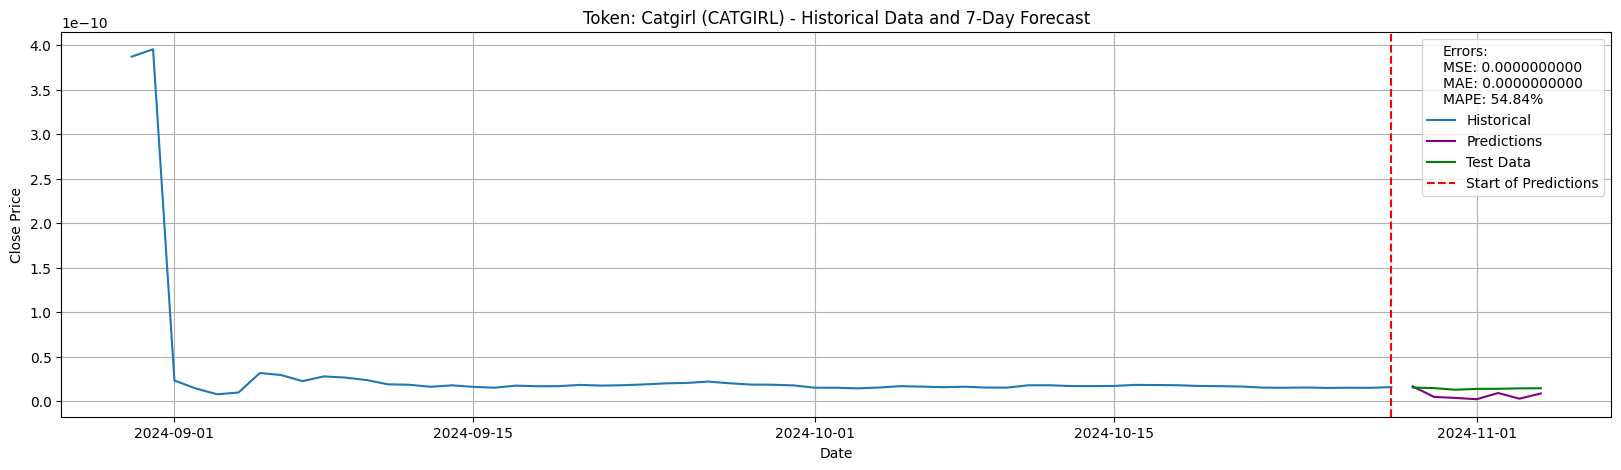

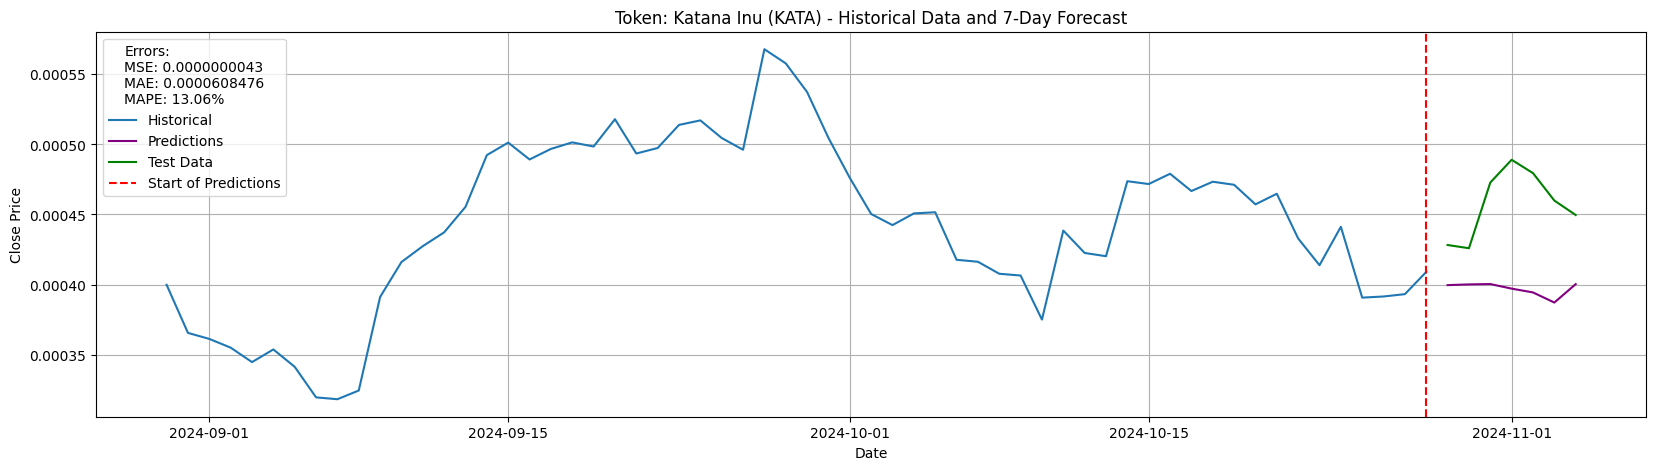

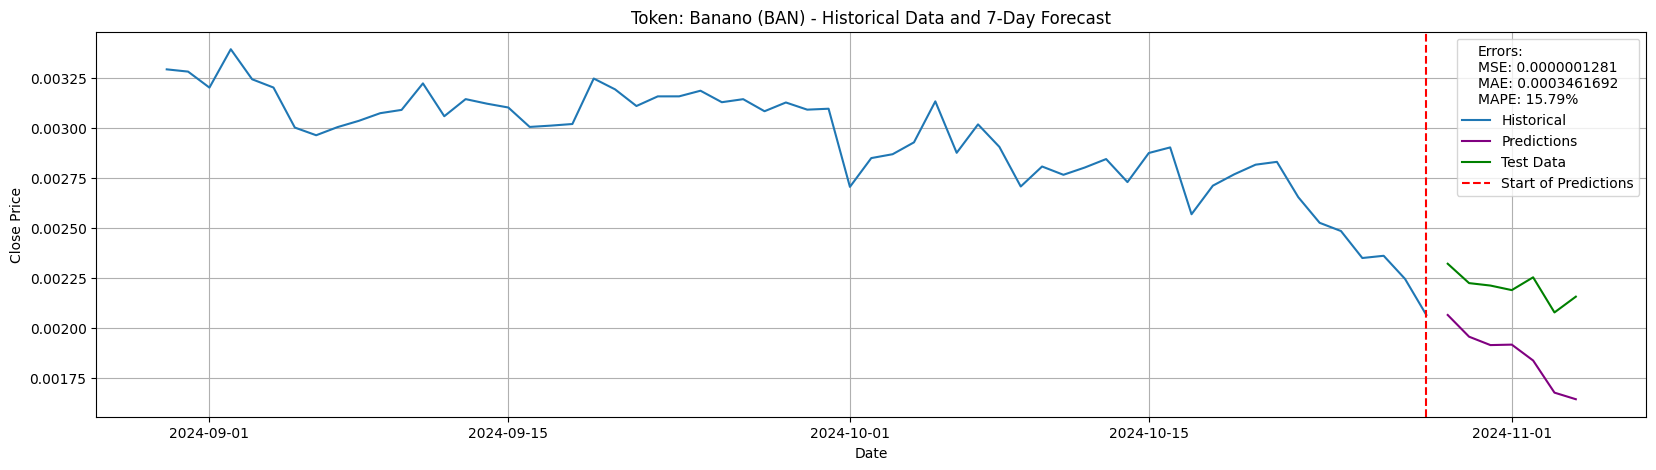

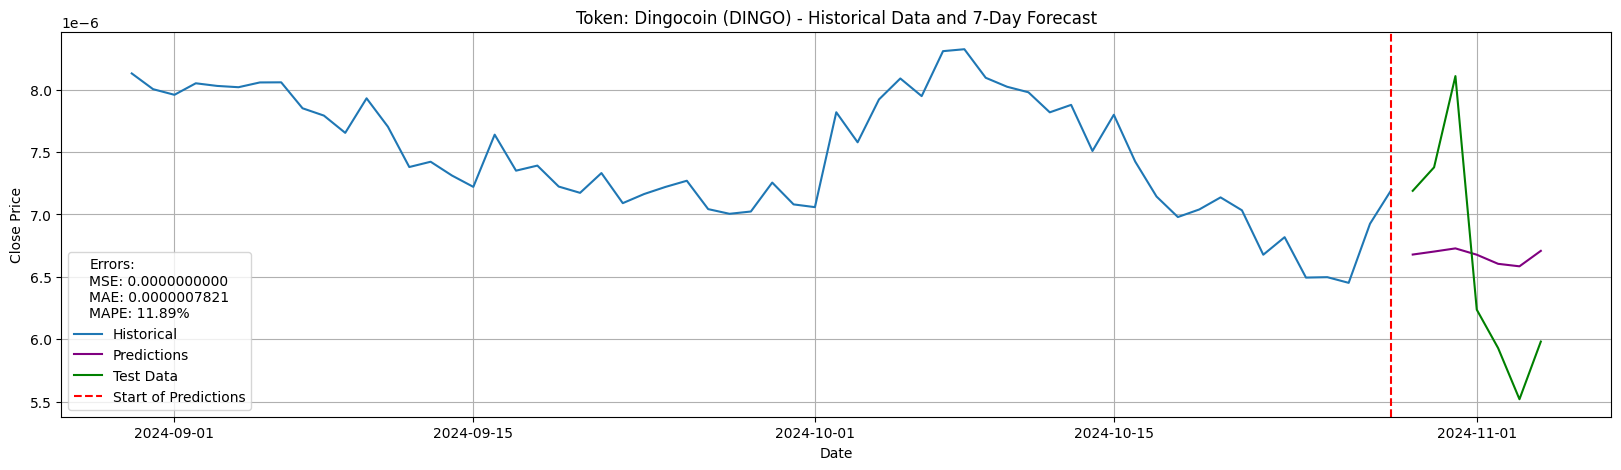

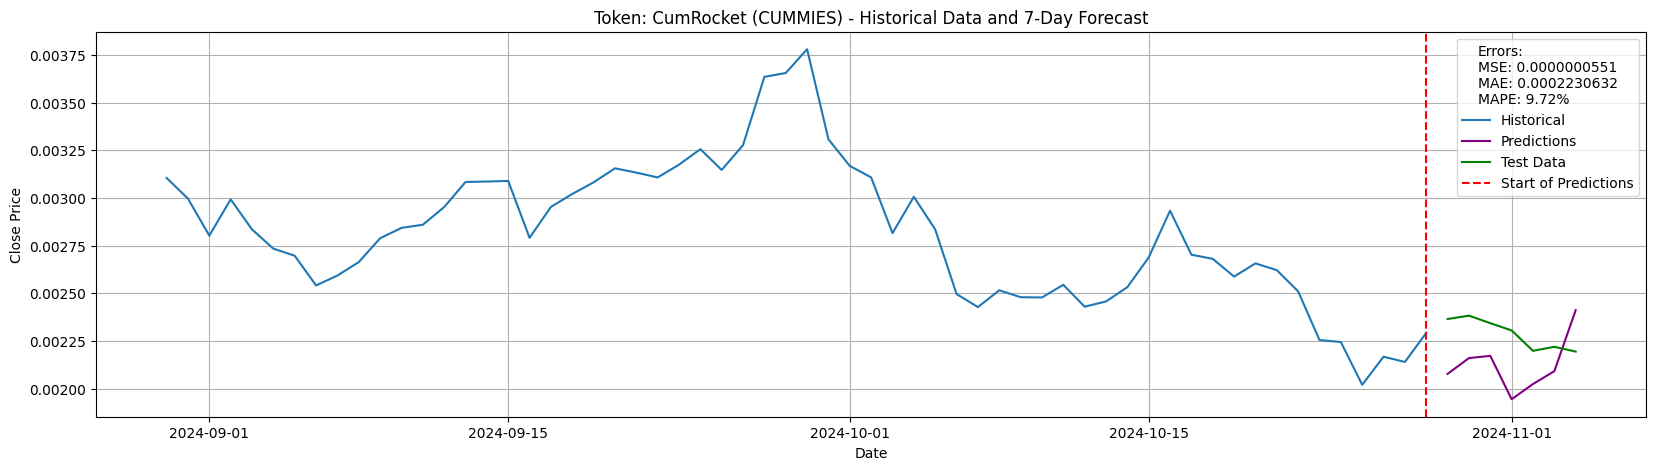

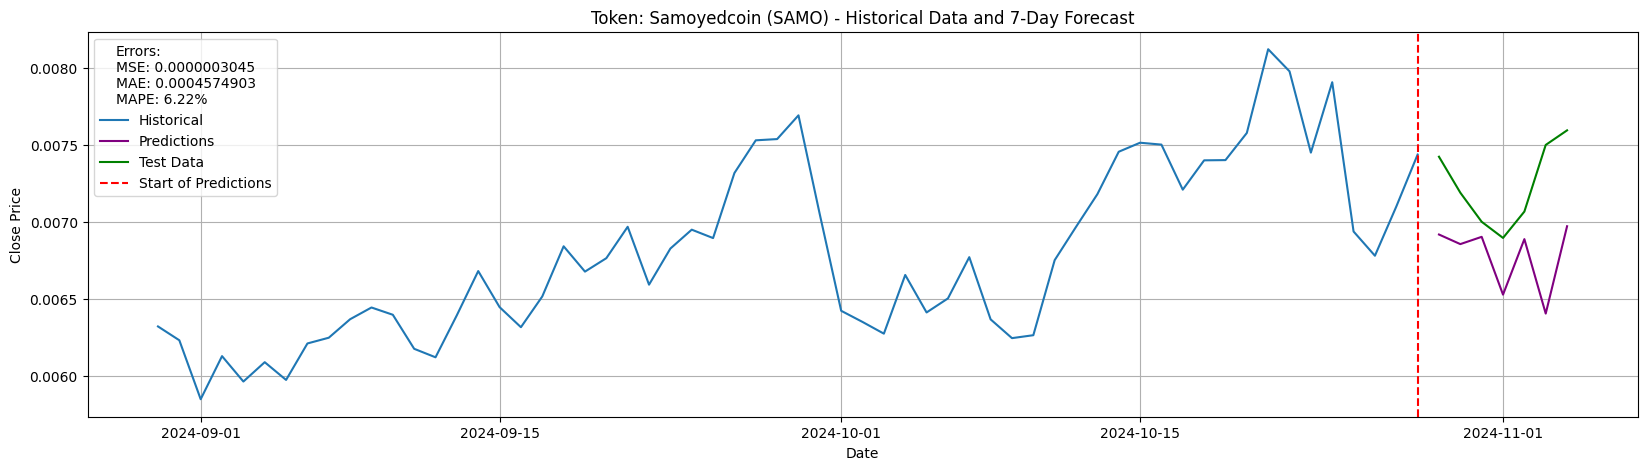

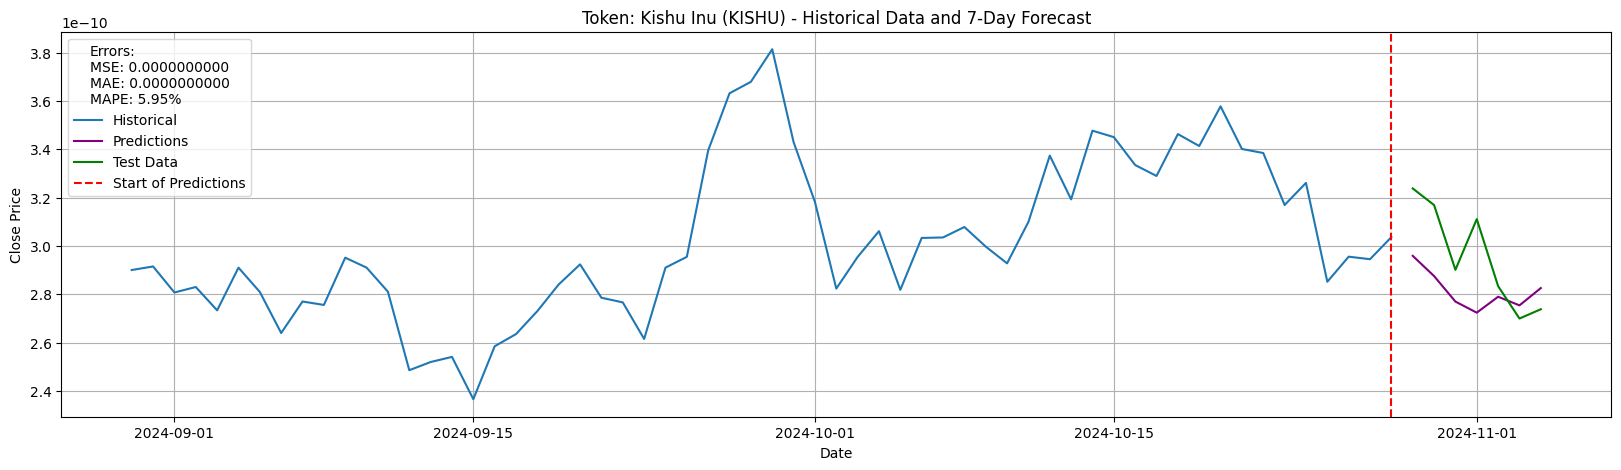

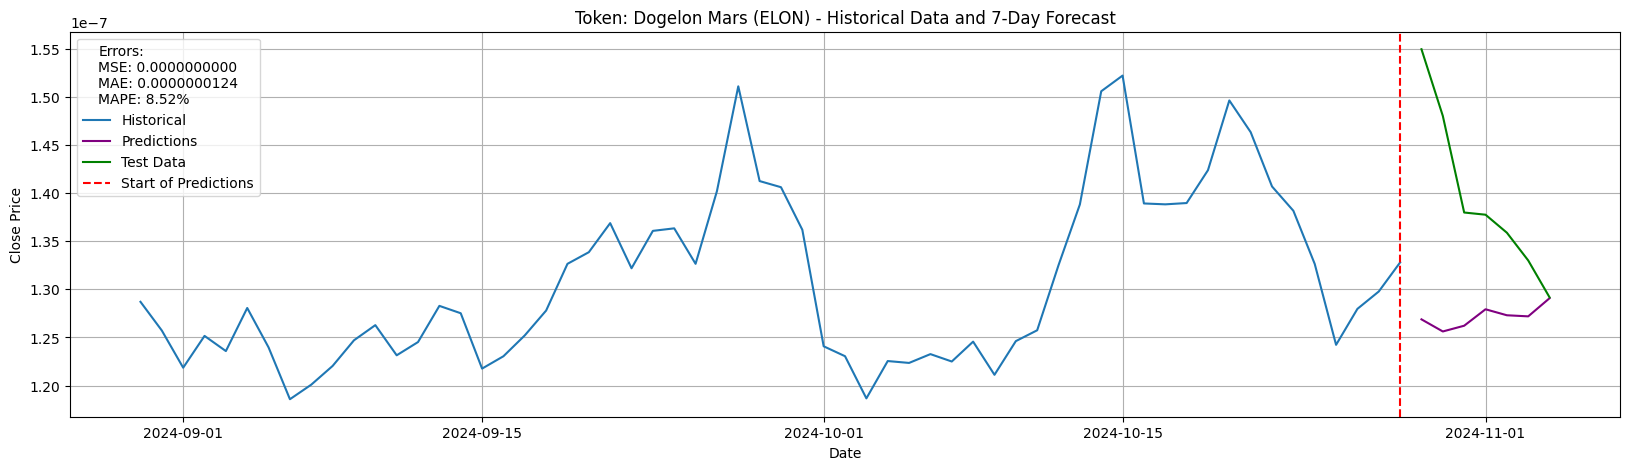

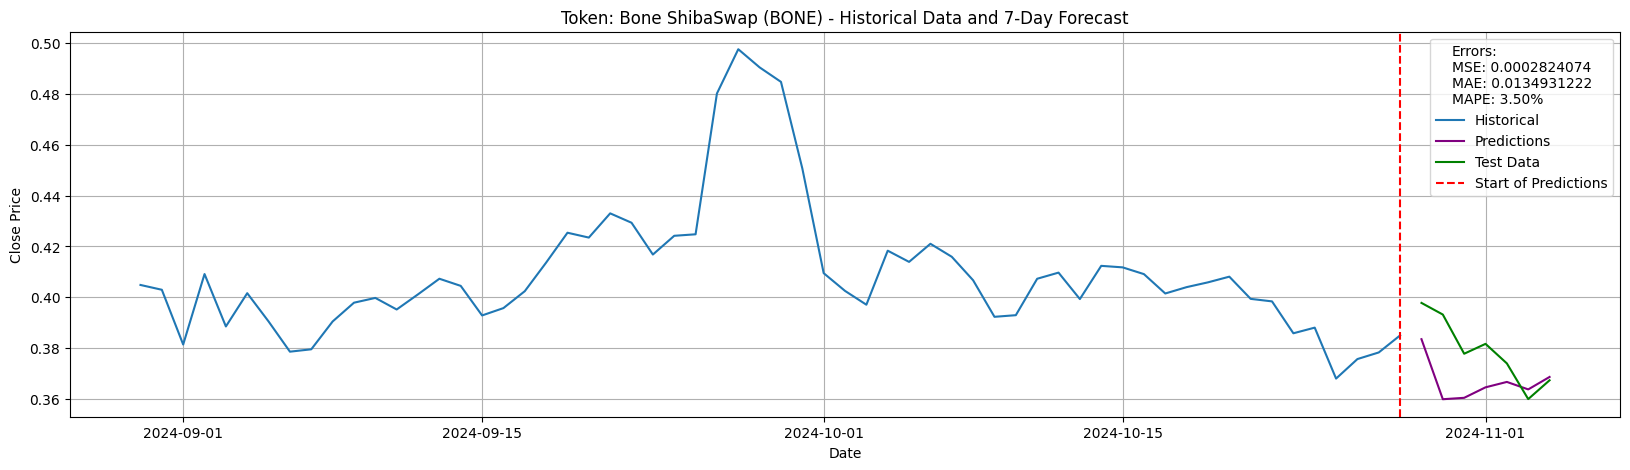

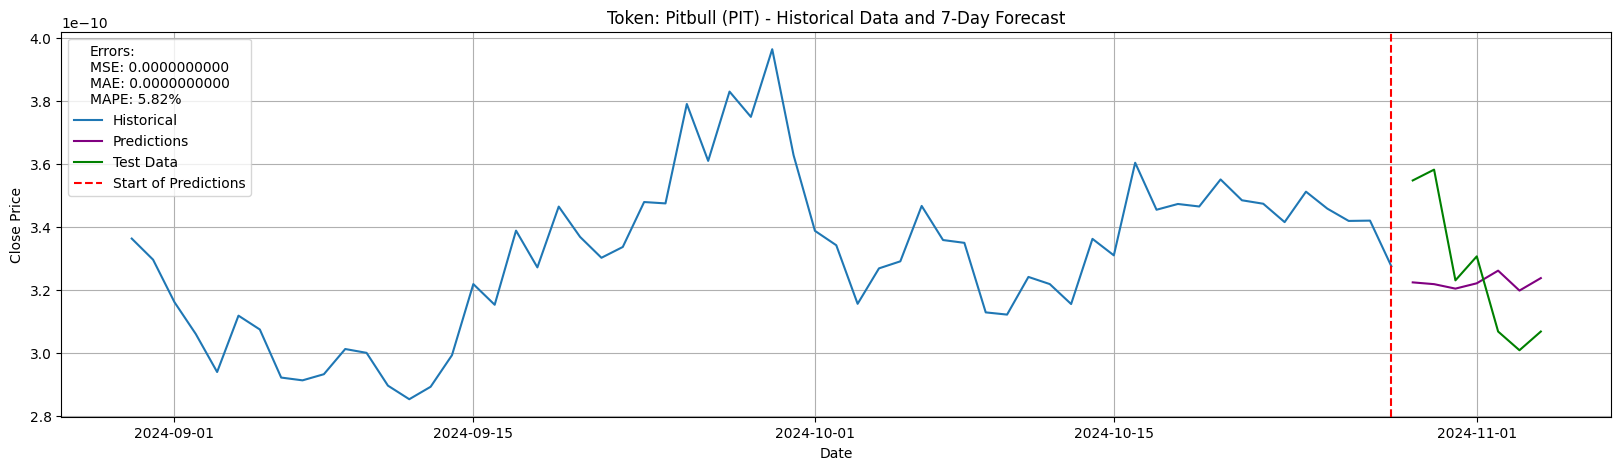

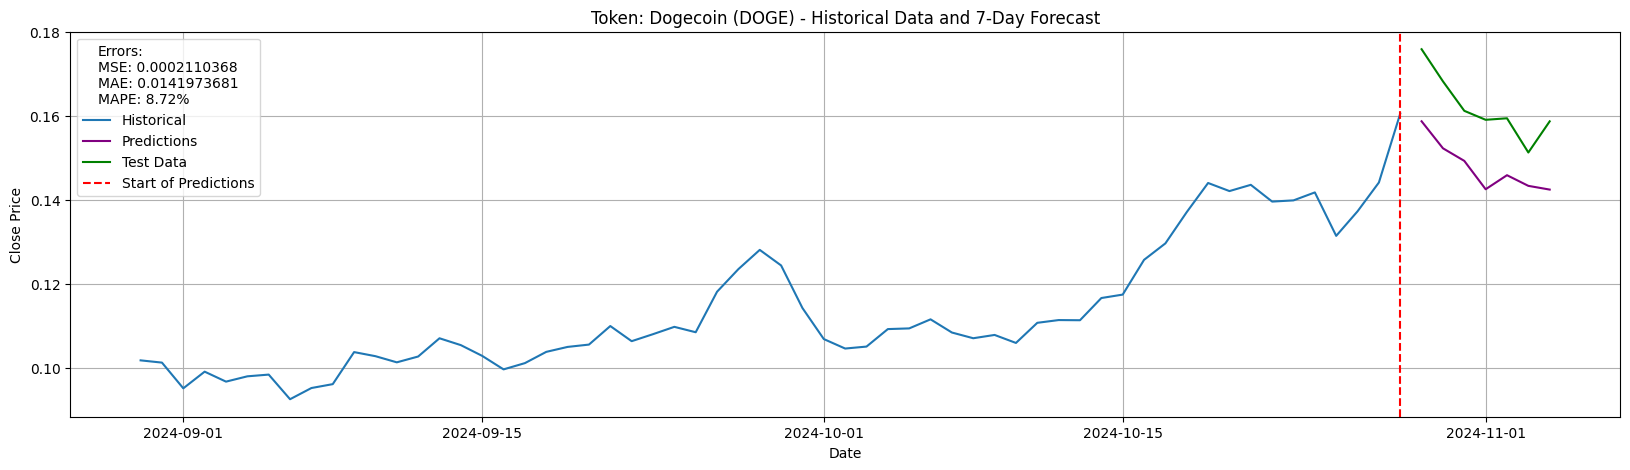

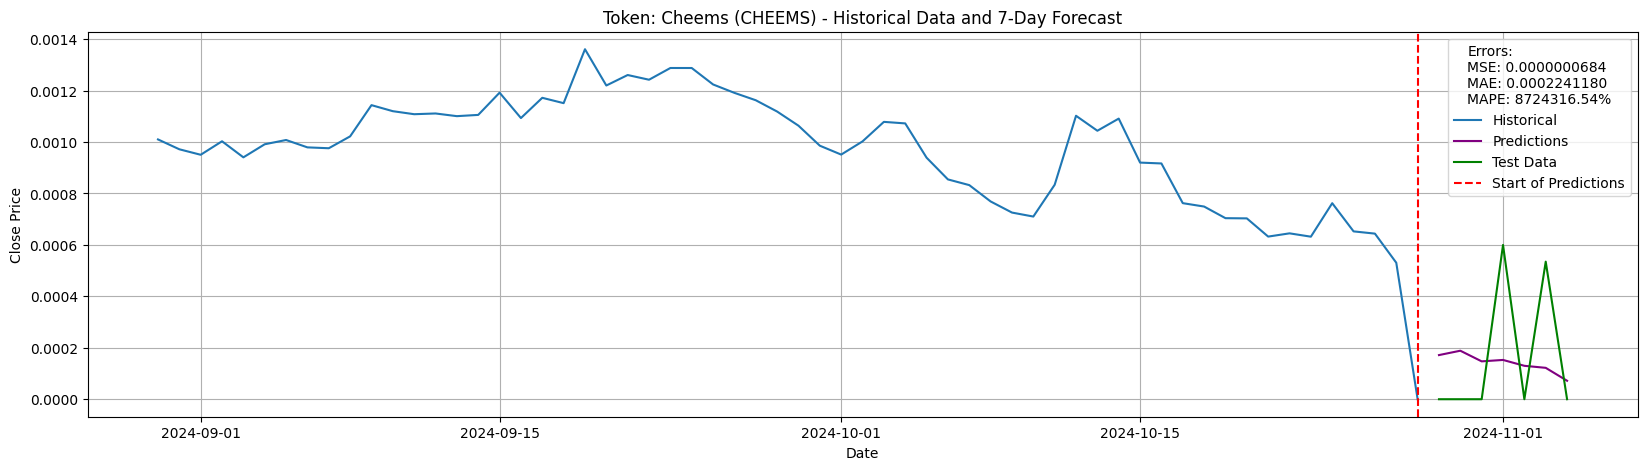

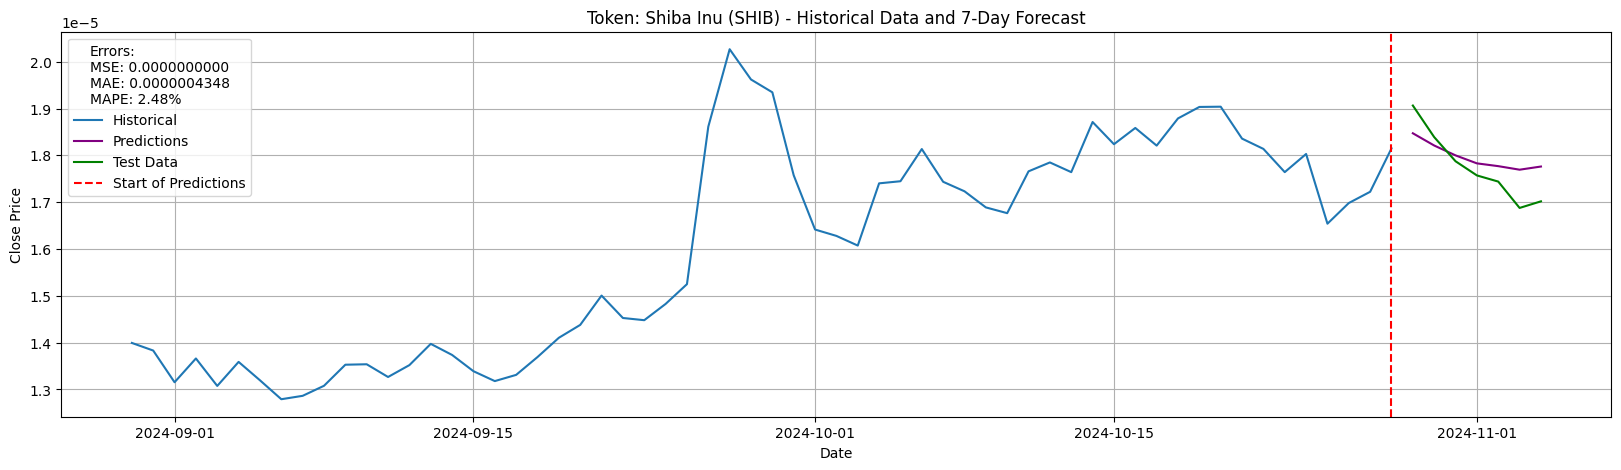

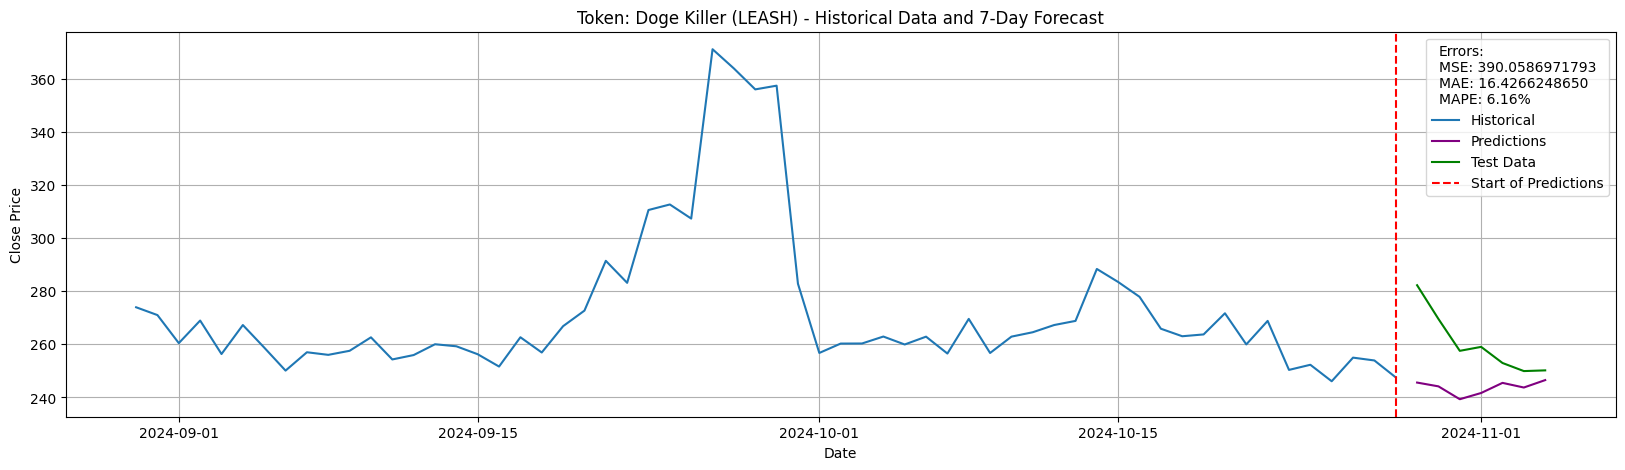

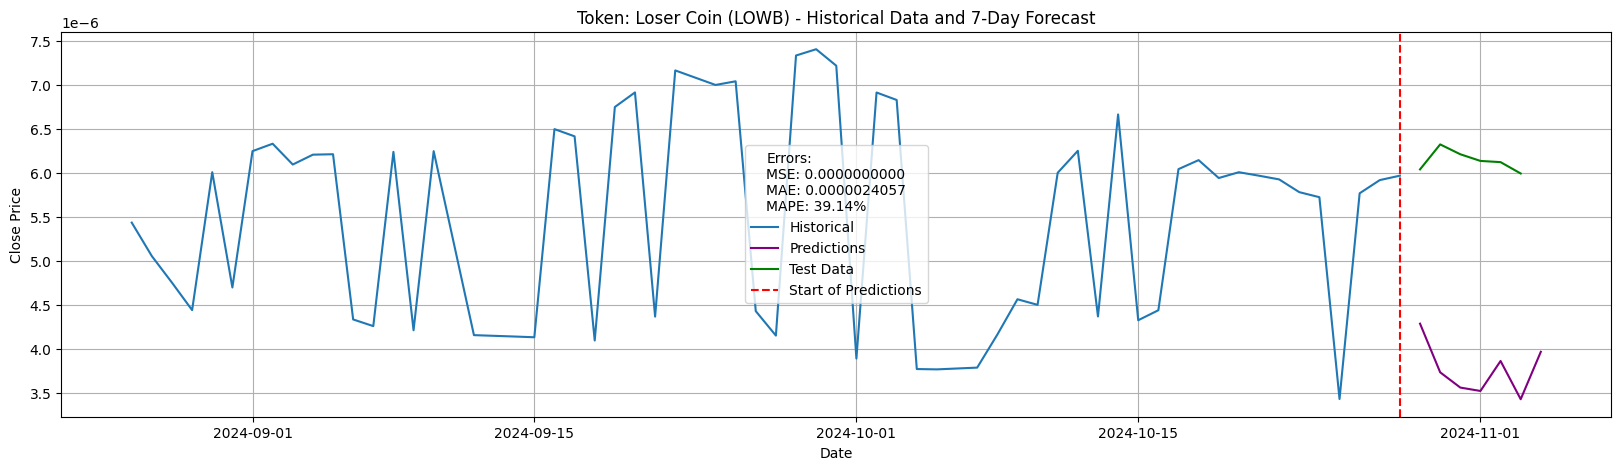

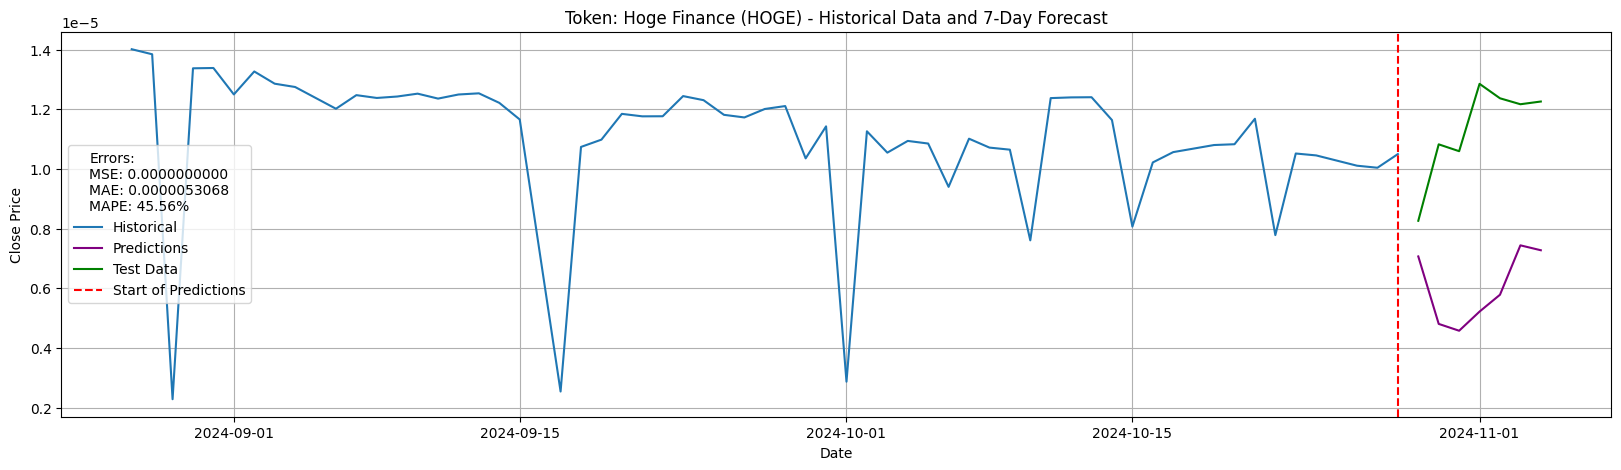

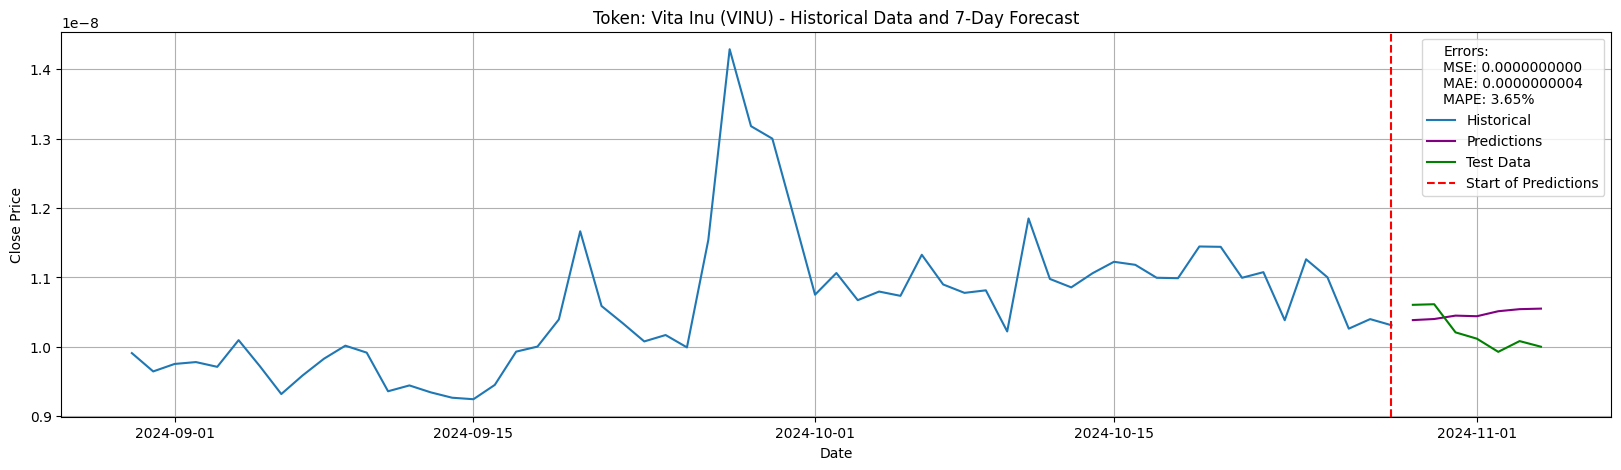

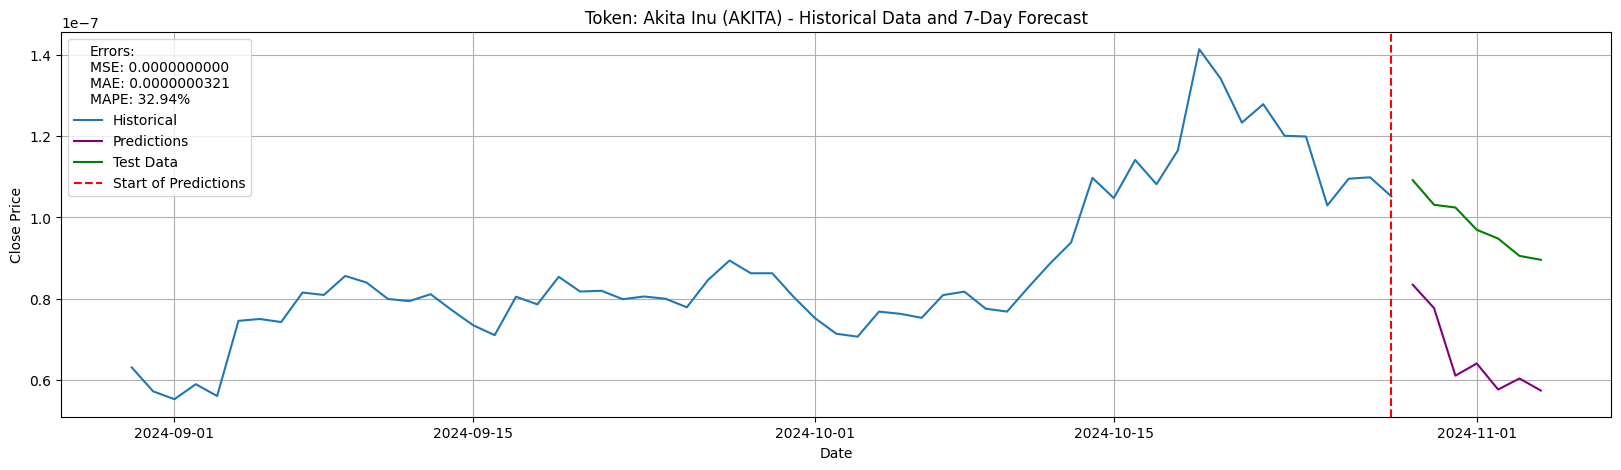

In [25]:
u.plot_predictions(train_data=meme_obj.og_train, predictions_x_days=meme_obj.og_pred, test_data=meme_test, last_data_points=60)